In [1]:
!pip install ultralytics supervision -q

In [2]:
from ultralytics import YOLO
import supervision as sv
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
model = YOLO('yolov8s.pt')
model.fuse()

YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


In [4]:
CLASS_NAMES_DICT = model.model.names

CLASS_NAMES_DICT

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [5]:
classes = [2, 3, 5, 7]

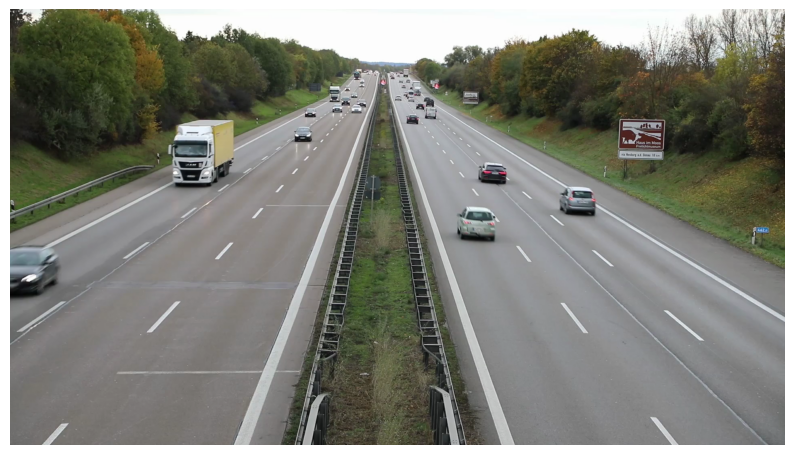

In [6]:
generator = sv.get_video_frames_generator('highway-vehicles.mp4')

iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame, (10, 10))


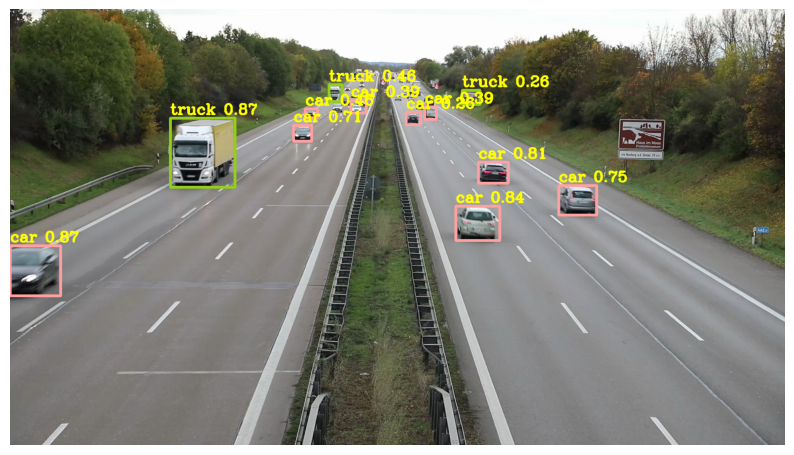

In [7]:
results = model(frame, verbose=False)[0]

detections = sv.Detections.from_ultralytics(results)
detections = detections[np.isin(detections.class_id, classes)]

box_annotator = sv.BoxAnnotator(thickness=6)

annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)

labels = []
for confidence, class_id in zip(detections.confidence, detections.class_id):
    label = f"{CLASS_NAMES_DICT[class_id]} {confidence:.2f}"
    labels.append(label)
for box, label in zip(detections.xyxy, labels):
  x1, y1, x2, y2 = box.astype(int)

  cv2.putText(
      annotated_frame, label, (x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1.2,
      color=(0, 255, 255), thickness=3)
sv.plot_image(annotated_frame, (10, 10))

# Track and Count Vehicles

In [8]:
sv.VideoInfo.from_video_path('highway-vehicles.mp4')

VideoInfo(width=1920, height=1080, fps=25, total_frames=1060)

In [9]:
LINE_START = sv.Point(0, 400)
LINE_END = sv.Point(1280, 400)


byte_tracker = sv.ByteTrack(frame_rate=25)

line_counter = sv.LineZone(start=LINE_START, end=LINE_END)

line_zone_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=1)

box_annotator = sv.BoxAnnotator(thickness=2)

trace_annotator = sv.TraceAnnotator(thickness=2, trace_length=50)

In [10]:
def process_frame(frame):
  results = model(frame, verbose=False)[0]

  detections = sv.Detections.from_ultralytics(results)

  detections = detections[np.isin(detections.class_id, classes)]

  detections = byte_tracker.update_with_detections(detections)

  labels = []
  for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id):
    label = f"{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:.2f}"
    labels.append(label)

  annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)

  annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

  for box, label in zip(detections.xyxy, labels):
      x1, y1, x2, y2 = box.astype(int)

      cv2.putText(
          annotated_frame, label, (x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1.2,
          color=(0, 255, 255), thickness=3
          )
  line_counter.trigger(detections)
  annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_counter)

  return annotated_frame

In [11]:
video_path = 'highway-vehicles.mp4'

video_cap = cv2.VideoCapture(video_path)

while True:
  success, frame = video_cap.read()

  if not success:
    break

  frame = cv2.resize(frame, (1280, 720))

  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

  processed_frame = process_frame(frame)

  cv2.imshow('Highway Vehicle Tracking And Counting', processed_frame)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break


video_cap.release()
cv2.destroyAllWindows()